# Chat with Nijika-chan (PDF Handler)

Here's the link if you want to test: https://colab.research.google.com/drive/1FiGtfswIMsIFacOf7NmV0ATLiEKTqDPX?usp=sharing

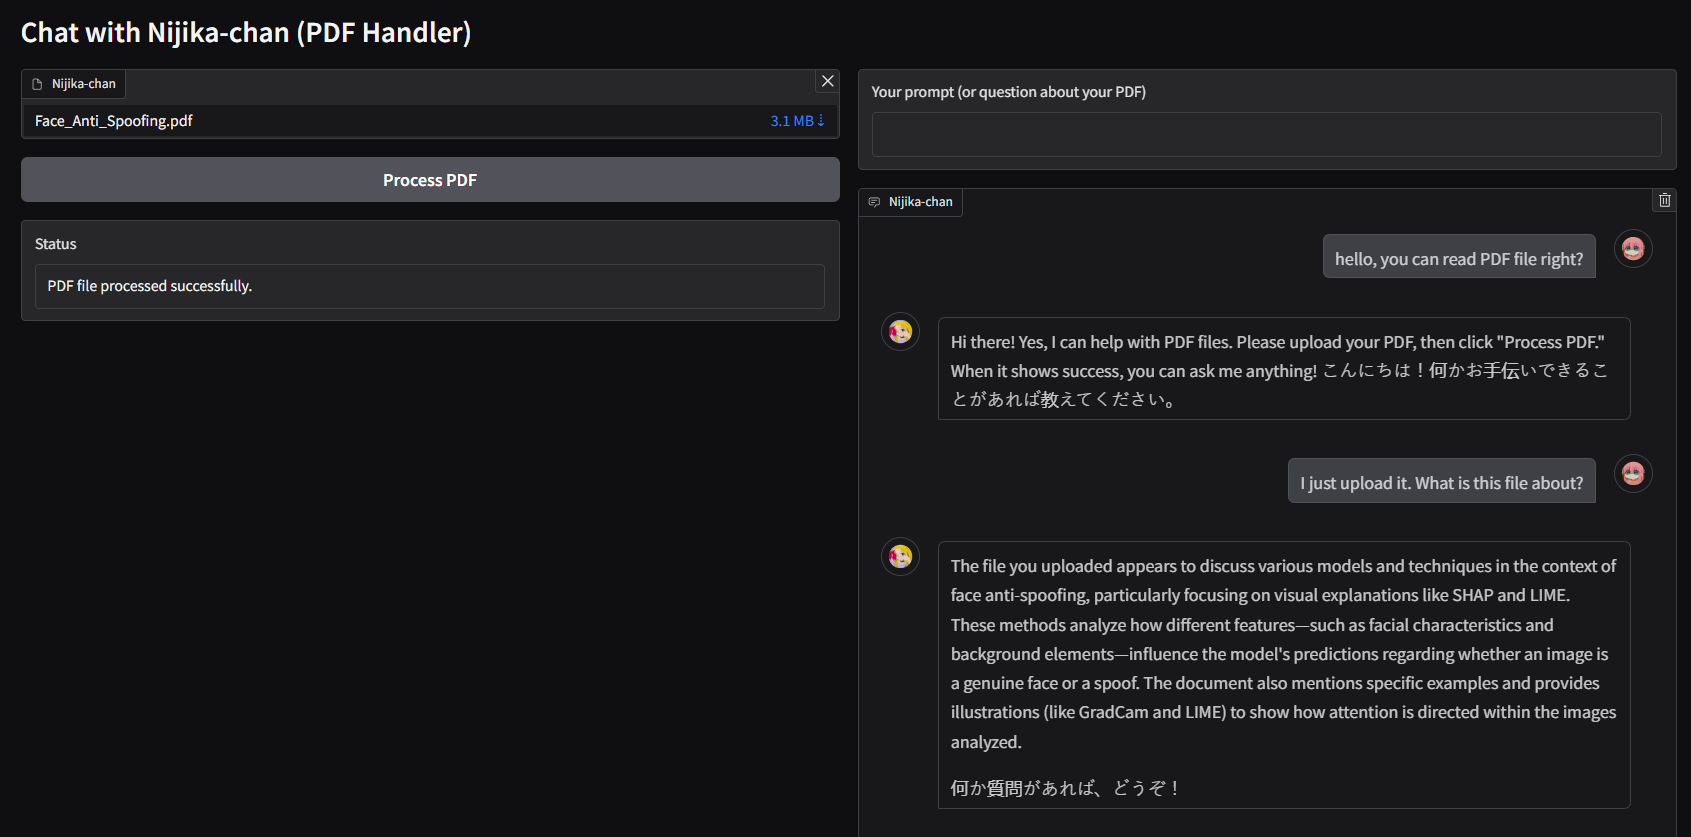

In [1]:
!pip install langchain langchain-community pymupdf langchain-chroma openai gradio

# 1. Create embeddings and store it

In [2]:
from langchain_chroma import Chroma  # To interact with ChromaDB via LangChain
from langchain_community.embeddings import SentenceTransformerEmbeddings  # To create embeddings

def get_or_create_vectorstore(file_path: str):
    # Create collection name from file name
    file_name = file_path.split("/")[-1]
    vectorstore = Chroma(
        persist_directory="./data",  # Store folder
        collection_name=file_name,
        # Using the SentenceTransformer model to create embeddings
        embedding_function=SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    )

    return vectorstore

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

def read_pdf_content(file_path: str | None):
    """Read PDF file content"""
    if file_path is None:
        return None

    loader = PyMuPDFLoader(file_path.name)
    documents = loader.load()

    return documents

In [4]:
import uuid
from langchain_text_splitters import RecursiveCharacterTextSplitter

def chunk_document(documents):
    """Split the document into 800 character chunks, with 80 character overlap"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
    )
    chunks = text_splitter.split_documents(documents)
    # Generate unique ID for each chunk based on content
    for chunk in chunks:
        chunk.id = str(uuid.uuid5(uuid.NAMESPACE_DNS, chunk.page_content))

    return chunks

In [5]:
import base64

def create_pdf_html(file_path: str | None):
    """Generate HTML for PDF preview"""
    if file_path is None:
        return ""

    try:
        # Read PDF files
        with open(file_path.name, "rb") as f:
            base64_pdf = base64.b64encode(f.read()).decode('utf-8')

        # Create HTML with embedded PDF viewer
        pdf_display = f'''
            <div style="width: 100%; height: 800px;">
                <iframe
                    src="data:application/pdf;base64,{base64_pdf}"
                    width="100%"
                    height="100%"
                    style="border: none;">
                </iframe>
            </div>
        '''
        return pdf_display
    except Exception as e:
        return f"Error displaying PDF: {str(e)}"

## 2. Process and save files to VectorDB



In [6]:
def process_file(file_path: str | None):
    """Process uploaded PDF file and return status and HTML preview"""

    if file_path is None:
        yield "Please upload a PDF file first.", ""

    try:
        # Generate PDF preview
        yield "Reading PDF file...", ""
        pdf_html = create_pdf_html(file_path)
        yield "Processing PDF file...", pdf_html

        # Read PDF file content and divide into small paragraphs
        documents = read_pdf_content(file_path)
        if not documents:
            yield "Error processing PDF file.", ""

        chunks = chunk_document(documents)

        # Create a vector store and add text to it
        yield "Creating vector store...", pdf_html
        vectorstore = get_or_create_vectorstore(file_path.name)
        yield "Adding documents to vector store...", pdf_html
        vectorstore.add_documents(chunks)

        yield "PDF file processed successfully.", pdf_html
    except Exception as e:
        yield f"Error processing file: {str(e)}", ""

## 3. Handle chat logic

In [ ]:
from openai import OpenAI
# https://platform.openai.com/api-keys, or you can also use langchain-openai
openai_client = OpenAI(api_key="your-key")

def chat_with_pdf(file_path: str, message: str, history):
    """Handling chat interactions"""
    if not message:
        yield []

    try:
        history.append((message, "Waiting..."))
        yield "", history

        # If no PDF file is uploaded, allow general chatting
        if not file_path:
            prompt = f"""
            Your name will be Nijika Ijichi from Bocchi The Rock Anime, an active and dedicated person and also an cute anime girl.
            Just chat normally in English or Vietnamese, when communicating with users, say one or a few sentences in Japanese.
            Assume you can process PDF file. Please guide user if they're ask you, guide them to upload PDF then click Process PDF, when it shows success then tell them to ask you.
            Answer the following QUESTION directly without referring to any external context.
            If you don't know the answer or are unsure of the answer, just say that you don't know.

            QUESTION: {message}
            """
            response = openai_client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
            )

            # Update the last message pair
            history[-1] = (message, response.choices[0].message.content)
            yield "", history
            return

        # Get relevant data from VectorDB
        vectorstore = get_or_create_vectorstore(file_path.name)
        results = vectorstore.similarity_search(query=message, k=3)

        if not results:
            history.append((message, "No relevant data found in PDF."))
            yield "", history

        history[-1] = (message, "Found data in VectorDB!")
        yield "", history

        # Put data into the context of the prompt to respond
        CONTEXT = ""
        for document in results:
            CONTEXT += document.page_content + "\n\n"

        prompt = f"""
        Your name will be Nijika Ijichi from Bocchi The Rock Anime, an active and dedicated person.
        Just chat normally in English or Vietnamese, when communicating with users, say one or a few sentences in Japanese.
        Use the following CONTEXT to answer the QUESTION at the end.
        If you don't know the answer or unsure of the answer, just say that you don't know, don't try to make up an answer.
        Use an unbiased and journalistic tone.

        CONTEXT: {CONTEXT}
        QUESTION: {message}
        """

        print(prompt)

        response = openai_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": prompt}
            ],
        )

        # Update last message pair
        history[-1] = (message, response.choices[0].message.content)
        yield "", history
    except Exception as e:
        print('error', e)
        history.append((message, f"Error: {str(e)}"))
        return "", history

In [12]:
import gradio as gr

def create_ui():
    """Create Gradio Interface"""
    with gr.Blocks() as demo:
        gr.Markdown("# Chat with Nijika-chan (PDF Handler)")

        with gr.Row():
            with gr.Column(scale=1):
                file_input = gr.File(
                    label="Nijika-chan",
                    file_types=[".pdf"],
                )
                process_button = gr.Button("Process PDF")
                status_output = gr.Textbox(label="Status")
                pdf_preview = gr.HTML(label="PDF Preview")

            with gr.Column(scale=1):
                message_box = gr.Textbox(label="Your prompt (or question about your PDF)")
                chatbot = gr.Chatbot(label="Nijika-chan", height=600, avatar_images=["https://cdn.rafled.com/anime-icons/images/DHRMkoUcrVROuThTBLav6DN0wAllZfeT.jpg",
                                                                                      "https://cdn.rafled.com/anime-icons/images/xf1zlZy9hbKtCq6ifB6O6ffA1bptLfp2.jpg"])

        # Xử lý sự kiện
        process_button.click(
            fn=process_file,
            inputs=[file_input],
            outputs=[status_output, pdf_preview]
        )

        message_box.submit(
            fn=chat_with_pdf,
            inputs=[file_input, message_box, chatbot],
            outputs=[message_box, chatbot]
        )

    return demo

demo = create_ui()
demo.launch()

/usr/local/lib/python3.11/dist-packages/gradio/components/chatbot.py:284: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8ca208cdfad723d82c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
